<a href="https://colab.research.google.com/github/UoUserusername/bigdataprogrammingH/blob/Ohyeeun/%EB%B9%85%EB%8D%B0%ED%94%84_%EC%97%AC%ED%96%89%EC%BD%98%ED%85%90%EC%B8%A0_%EC%B6%94%EC%B2%9C__%ED%98%91%EC%97%85_%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Uer-Based 협업 필터링 기법을 활용하여 사용자의 여행 성향과 유사한 사람들을 기반으로 여행지를 추천하는 시스템

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 정확한 경로 설정
base_path = "/content/drive/MyDrive/travel/"

# CSV 불러오기
traveler_df = pd.read_csv(base_path + "tn_traveller_master_여행객 Master_G.csv", encoding='cp949')
activity_df = pd.read_csv(base_path + "tn_activity_his_활동내역_G.csv", encoding='cp949')
visit_df = pd.read_csv(base_path + "tn_visit_area_info_방문지정보_G.csv", encoding='utf-8')
travel_df = pd.read_csv(base_path +"tn_travel_여행_G.csv",  encoding='utf-8')
#
consume_df = pd.read_csv(base_path + "tn_activity_consume_his_활동소비내역_G.csv", encoding='utf-8')

In [ ]:
# Step 1. 필요한 컬럼만 선택
consume_df = consume_df[[
    'VISIT_AREA_ID',
    'PAYMENT_DT',
    'PAYMENT_AMT_WON',
    'ROAD_NM_ADDR',
    'STORE_NM',
    'ACTIVITY_TYPE_CD'
]]

# Step 2. VISIT_AREA_ID 타입 정제
consume_df['VISIT_AREA_ID'] = consume_df['VISIT_AREA_ID'].astype(str)

# Step 3. 날짜 파싱 → 계절 생성
consume_df['PAYMENT_DT'] = pd.to_datetime(consume_df['PAYMENT_DT'], errors='coerce')
consume_df['MONTH'] = consume_df['PAYMENT_DT'].dt.month

def get_season(month):
    if pd.isna(month): return None
    if month in [12, 1, 2]: return '겨울'
    elif month in [3, 4, 5]: return '봄'
    elif month in [6, 7, 8]: return '여름'
    else: return '가을'

consume_df['SEASON'] = consume_df['MONTH'].apply(get_season)

# Step 4. REGION 추출
consume_df['REGION'] = consume_df['ROAD_NM_ADDR'].fillna('').str.extract(r'^(\S+도|\S+시|\S+특별시|\S+광역시)')

# Step 5. 요약 계산
consume_summary = (
    consume_df.groupby('VISIT_AREA_ID')
    .agg({
        'PAYMENT_AMT_WON': 'mean',
        'SEASON': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'REGION': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'ACTIVITY_TYPE_CD': lambda x: x.mode().iloc[0] if not x.mode().empty else None
    })
    .reset_index()
    .rename(columns={
        'PAYMENT_AMT_WON': 'AVG_PAYMENT_AMT',
        'SEASON': 'DOMINANT_SEASON',
        'REGION': 'DOMINANT_REGION',
        'ACTIVITY_TYPE_CD': 'MAIN_ACTIVITY_TYPE'
    })
)


<ipython-input-8-703b7e9f321f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consume_df['VISIT_AREA_ID'] = consume_df['VISIT_AREA_ID'].astype(str)
<ipython-input-8-703b7e9f321f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consume_df['PAYMENT_DT'] = pd.to_datetime(consume_df['PAYMENT_DT'], errors='coerce')
<ipython-input-8-703b7e9f321f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
store_nm_summary = (
    consume_df[['VISIT_AREA_ID', 'STORE_NM']]
    .dropna()
    .groupby('VISIT_AREA_ID')
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

In [ ]:

# 활동(Activity) + 여행(TRAVEL) 병합
merged_df = activity_df.merge(travel_df[['TRAVEL_ID', 'TRAVELER_ID']], on='TRAVEL_ID', how='left')

# 사람 정보 병합
merged_df = merged_df.merge(traveler_df, on='TRAVELER_ID', how='left')

merged_df = merged_df.merge(visit_df, on='VISIT_AREA_ID', how='left')
merged_df['VISIT_AREA_ID'] = merged_df['VISIT_AREA_ID'].astype(str)
consume_summary['VISIT_AREA_ID'] = consume_summary['VISIT_AREA_ID'].astype(str)
# refined_df와 병합 (RAM 안전함)
merged_df = merged_df.merge(consume_summary, on='VISIT_AREA_ID', how='left')
merged_df = merged_df.merge(store_nm_summary, on='VISIT_AREA_ID', how='left')


In [ ]:
selected_columns = [
    # 여행 ID 및 사용자 ID
    'TRAVEL_ID_x', 'TRAVELER_ID',

    # 사용자 정보
    'AGE_GRP', 'GENDER', 'INCOME', 'HOUSE_INCOME',
    'FAMILY_MEMB', 'TRAVEL_COMPANIONS_NUM', 'TRAVEL_TERM',

    # 여행 성향 (존재하는 스타일 및 선호 지역)
    'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SGG_1',
    'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3',
    'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 'TRAVEL_STYL_6',
    'TRAVEL_STYL_7', 'TRAVEL_STYL_8',
    'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3',

    # 활동 정보
    'ACTIVITY_TYPE_CD', 'ACTIVITY_DTL', 'ACTIVITY_ETC',
    'EXPND_SE', 'RSVT_YN', 'ADMISSION_SE',

    # 방문지 정보
    'VISIT_AREA_ID', 'VISIT_AREA_NM', 'ROAD_NM_ADDR', 'LOTNO_ADDR',
    'X_COORD', 'Y_COORD', 'RESIDENCE_TIME_MIN', 'REVISIT_INTENTION',

     # VISIT_AREA_ID 기반 소비 요약
    'AVG_PAYMENT_AMT',
    'DOMINANT_SEASON',
    'DOMINANT_REGION',
    'MAIN_ACTIVITY_TYPE',

    # STORE_NM
    'STORE_NM',

    'TRAVEL_STATUS_ACCOMPANY'
]


In [ ]:
refined_df = merged_df[selected_columns].drop_duplicates()


In [ ]:
refined_df.to_csv("/content/drive/MyDrive/travel/필터링용_데이터.csv", index=False)

In [ ]:
refined_df.head()


,TRAVEL_ID_x,TRAVELER_ID,AGE_GRP,GENDER,INCOME,HOUSE_INCOME,FAMILY_MEMB,TRAVEL_COMPANIONS_NUM,TRAVEL_TERM,TRAVEL_LIKE_SIDO_1,...,X_COORD,Y_COORD,RESIDENCE_TIME_MIN,REVISIT_INTENTION,AVG_PAYMENT_AMT,DOMINANT_SEASON,DOMINANT_REGION,MAIN_ACTIVITY_TYPE,STORE_NM,TRAVEL_STATUS_ACCOMPANY
0,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,127.425684,36.439598,30.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
1,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.854664,36.962309,90.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
2,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.287070,36.619450,30.0,2.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
3,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.291159,36.607067,780.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
4,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.990157,36.398710,30.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행


In [ ]:
# 1. 삭제해도 되는 열 제거
refined_df = refined_df.drop(columns=['ACTIVITY_ETC', 'ADMISSION_SE'])

# 2. '기타'로 채울 열들
refined_df['ACTIVITY_DTL'] = refined_df['ACTIVITY_DTL'].fillna('기타')

# 3. 범주형 - 결측치를 '미기재' 등으로 채우기
refined_df['RSVT_YN'] = refined_df['RSVT_YN'].fillna('미기재')
refined_df['EXPND_SE'] = refined_df['EXPND_SE'].fillna('미기재')

# 4. 중간 결측치는 최빈값 또는 0으로 채우기
refined_df['TRAVEL_MOTIVE_2'] = refined_df['TRAVEL_MOTIVE_2'].fillna('없음')
refined_df['TRAVEL_MOTIVE_3'] = refined_df['TRAVEL_MOTIVE_3'].fillna('없음')
refined_df['REVISIT_INTENTION'] = refined_df['REVISIT_INTENTION'].fillna('미기재')
refined_df['RESIDENCE_TIME_MIN'] = refined_df['RESIDENCE_TIME_MIN'].fillna(0)

In [ ]:
print(refined_df[['TRAVEL_COMPANIONS_NUM', 'RESIDENCE_TIME_MIN']].dtypes)


TRAVEL_COMPANIONS_NUM      int64
RESIDENCE_TIME_MIN       float64
dtype: object


In [ ]:
# traveler_id 기준으로 활동 이력을 리스트화
user_activity_map = refined_df.groupby('TRAVELER_ID')['ACTIVITY_TYPE_CD'].apply(list)

In [ ]:
# 결과 저장
refined_df.to_csv("/content/drive/MyDrive/travel/전처리_데이터.csv", index=False)
# refined_df.head()
# print(refined_df.columns.tolist())

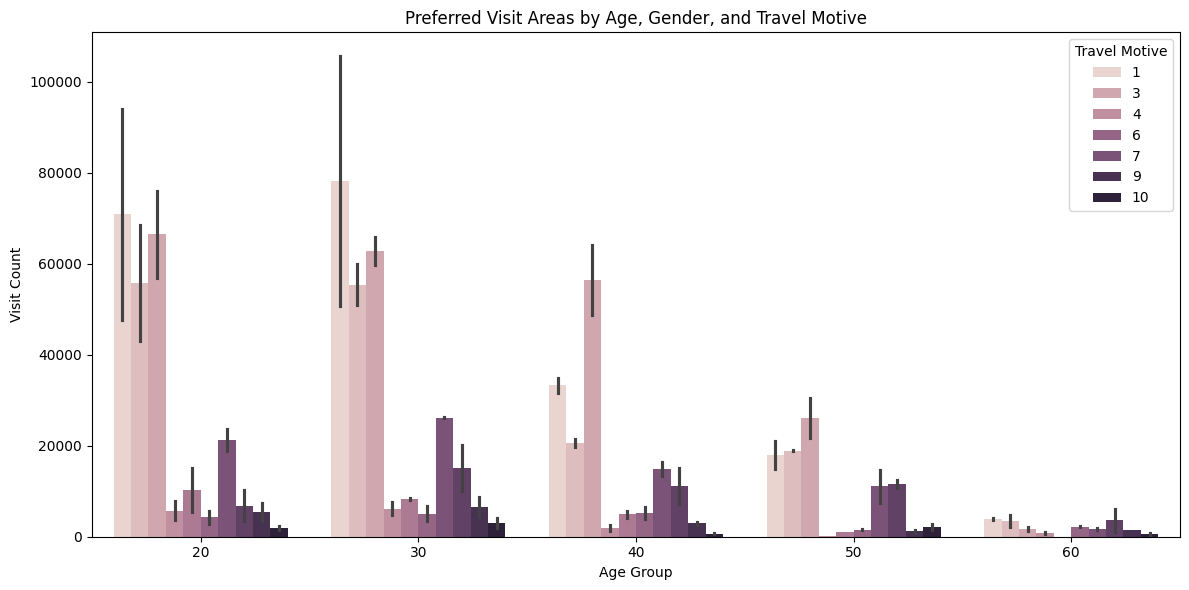

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = refined_df.groupby(['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1'])['VISIT_AREA_NM'].count().reset_index()
grouped.rename(columns={'VISIT_AREA_NM': 'visit_count'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='AGE_GRP', y='visit_count', hue='TRAVEL_MOTIVE_1')
plt.title('Preferred Visit Areas by Age, Gender, and Travel Motive')
plt.xlabel('Age Group')
plt.ylabel('Visit Count')
plt.legend(title='Travel Motive')
plt.tight_layout()
plt.show()


In [ ]:
# 고유값(unique) 확인
print("여행 스타일 (TRAVEL_STYL_1):")
print(refined_df['TRAVEL_STYL_1'].dropna().unique())

print("\n여행 동기 (TRAVEL_MOTIVE_1):")
print(refined_df['TRAVEL_MOTIVE_1'].dropna().unique())

# 값별 개수 확인
print("여행 스타일 (TRAVEL_STYL_1) - 값 분포:")
print(refined_df['TRAVEL_STYL_1'].value_counts())

print("\n여행 동기 (TRAVEL_MOTIVE_1) - 값 분포:")
print(refined_df['TRAVEL_MOTIVE_1'].value_counts())


여행 스타일 (TRAVEL_STYL_1):
[4 7 1 5 2 3 6]

여행 동기 (TRAVEL_MOTIVE_1):
[ 7  2  3  1  9  5  8  4  6 10]
여행 스타일 (TRAVEL_STYL_1) - 값 분포:
TRAVEL_STYL_1
2    419120
4    336967
1    301288
3    209849
6    121752
5    104112
7     61987
Name: count, dtype: int64

여행 동기 (TRAVEL_MOTIVE_1) - 값 분포:
TRAVEL_MOTIVE_1
3     427167
1     408062
2     308304
7     149944
8      96452
5      48841
6      36430
9      33691
4      29513
10     16671
Name: count, dtype: int64


In [ ]:
# 미기재 제거 (정확하게 모든 관련 컬럼에 대해 적용)
for col in ['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN']:
    refined_df = refined_df[~refined_df[col].astype(str).str.contains('미기재', na=False)]
    refined_df[col] = pd.to_numeric(refined_df[col], errors='coerce')

# 그 외 숫자형 컬럼도 전처리
refined_df['TRAVEL_COMPANIONS_NUM'] = pd.to_numeric(refined_df['TRAVEL_COMPANIONS_NUM'], errors='coerce')

# 최종 NaN 제거
refined_df = refined_df.dropna(subset=['REVISIT_INTENTION', 'RESIDENCE_TIME_MIN', 'TRAVEL_COMPANIONS_NUM'])


<ipython-input-21-10d5320731ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_df[col] = pd.to_numeric(refined_df[col], errors='coerce')


1. Uer-Based 협업 필터링 기법을 활용하여 사용자의 여행 성향과 유사한 사람들을 기반으로 여행지를 추천하는 시스템

In [ ]:
# 사용자 기반 협업 필터링
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 유저-장소 평점 데이터 생성
interaction_df = refined_df[['TRAVELER_ID', 'VISIT_AREA_NM', 'REVISIT_INTENTION']].dropna()
user_item_matrix = interaction_df.pivot_table(index='TRAVELER_ID', columns='VISIT_AREA_NM', values='REVISIT_INTENTION')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_sim = cosine_similarity(user_item_matrix_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

# 사용자 입력 정보
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

# 입력 조건과 가장 유사한 유저 찾기
def find_most_similar_user(refined_df, user_input):
    filtered = refined_df[
        (refined_df['AGE_GRP'].astype(str) == user_input['AGE_GRP']) &
        (refined_df['GENDER'] == user_input['GENDER']) &
        (refined_df['TRAVEL_COMPANIONS_NUM'] == user_input['TRAVEL_COMPANIONS_NUM'])
    ]
    if filtered.empty:
        print("조건에 맞는 사용자가 없습니다. 전체 중 임의 사용자로 추천합니다.")
        return refined_df['TRAVELER_ID'].iloc[0]
    else:
        return filtered['TRAVELER_ID'].value_counts().idxmax()

# 추천 함수 정의
def recommend_places_for_user(target_user_id, top_n=5):
    if target_user_id not in user_item_matrix.index:
        print("존재하지 않는 사용자입니다.")
        return

    # 1. 유사 사용자 선택
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)
    similar_users = sim_scores.sort_values(ascending=False).head(5)

    # 2. 가중 평점 계산
    weighted_scores = pd.Series(dtype=np.float64)
    for other_user_id, sim_score in similar_users.items():
        other_user_ratings = user_item_matrix.loc[other_user_id]
        weighted_scores = weighted_scores.add(other_user_ratings * sim_score, fill_value=0)

    # 3. 이미 가본 장소 제거
    known_places = user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notnull()].index
    recommendations = weighted_scores.drop(known_places, errors='ignore')
    top_recommendations = recommendations.sort_values(ascending=False).head(top_n)

    # 4. 추천 결과 출력
    for place, score in top_recommendations.items():
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]

        avg_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit = place_data['REVISIT_INTENTION'].mean()

        # 이 장소에 평점 준 유사 사용자들의 평균 유사도
        contributing_users = [
            (uid, sim_scores[uid]) for uid in similar_users.index
            if place in user_item_matrix.loc[uid] and not pd.isna(user_item_matrix.loc[uid][place])
        ]
        avg_similarity = np.mean([sim for uid, sim in contributing_users]) if contributing_users else 0.0

        print(f"추천 장소: {place}")
        print(f"  - 예측 평점: {score:.2f}")
        print(f"  - 기여 유사도(평균): {avg_similarity:.3f}")
        print(f"  - 평균 체류 시간: {avg_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit:.1f}점\n")

# 실행
target_user_id = find_most_similar_user(refined_df, user_input)
recommend_places_for_user(target_user_id=target_user_id, top_n=5)


추천 장소: 라한 호텔 전주
  - 예측 평점: 19.08
  - 기여 유사도(평균): 0.954
  - 평균 체류 시간: 218.3분
  - 평균 재방문 의향: 4.9점

추천 장소: 여수 미남크루즈
  - 예측 평점: 18.13
  - 기여 유사도(평균): 0.954
  - 평균 체류 시간: 113.2분
  - 평균 재방문 의향: 4.0점

추천 장소: 더 휴식 아늑 호텔 대전 용전 2호점
  - 예측 평점: 14.33
  - 기여 유사도(평균): 0.955
  - 평균 체류 시간: 177.1분
  - 평균 재방문 의향: 4.7점

추천 장소: 고사포해수욕장
  - 예측 평점: 14.33
  - 기여 유사도(평균): 0.955
  - 평균 체류 시간: 90.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 디피랑
  - 예측 평점: 14.33
  - 기여 유사도(평균): 0.955
  - 평균 체류 시간: 60.0분
  - 평균 재방문 의향: 5.0점



In [ ]:
#협업 필터링
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# 1. 사용자-장소 평점 행렬 생성 함수
def create_user_item_matrix(df):
    interaction_df = df[['TRAVELER_ID', 'VISIT_AREA_NM', 'REVISIT_INTENTION']].dropna()
    user_item = interaction_df.pivot_table(
        index='TRAVELER_ID', columns='VISIT_AREA_NM', values='REVISIT_INTENTION'
    ).fillna(0)
    return user_item

# 2. 사용자 간 유사도 계산 함수
def calculate_user_similarity(user_item_matrix):
    sim = cosine_similarity(user_item_matrix)
    return pd.DataFrame(sim, index=user_item_matrix.index, columns=user_item_matrix.index)

# 3. 라벨 인코딩 (사용자 입력값 포함) 함수
def encode_categorical_columns(df, user_input, categorical_cols):
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        combined = df[col].astype(str).tolist() + [str(user_input[col])]
        le.fit(combined)
        df[col + '_LABEL'] = le.transform(df[col].astype(str))
        label_encoders[col] = le
    return df, label_encoders

# 4. 조건에 가장 근접한 사용자 찾기 함수
def find_similar_user(df, user_input, label_encoders):
    df = df.copy()
    df['match_score'] = 0

    # 나이 그룹
    age_label = label_encoders['AGE_GRP'].transform([user_input['AGE_GRP']])[0]
    df.loc[df['AGE_GRP_LABEL'] == age_label, 'match_score'] += 1

    # 성별
    gender_label = label_encoders['GENDER'].transform([user_input['GENDER']])[0]
    df.loc[df['GENDER_LABEL'] == gender_label, 'match_score'] += 1

    # 여행 인원: 정확히 일치하면 +1, 1 차이면 +0.5
    companions_diff = abs(df['TRAVEL_COMPANIONS_NUM'] - user_input['TRAVEL_COMPANIONS_NUM'])
    df.loc[companions_diff == 0, 'match_score'] += 1
    df.loc[companions_diff == 1, 'match_score'] += 0.5

    # 여행 동기
    motive_label = label_encoders['TRAVEL_MOTIVE_1'].transform([str(user_input['TRAVEL_MOTIVE_1'])])[0]
    df.loc[df['TRAVEL_MOTIVE_1_LABEL'] == motive_label, 'match_score'] += 1

    # 여행 스타일
    style_label = label_encoders['TRAVEL_STYL_1'].transform([str(user_input['TRAVEL_STYL_1'])])[0]
    df.loc[df['TRAVEL_STYL_1_LABEL'] == style_label, 'match_score'] += 1

    # 동행자 관계
    accompany_label = label_encoders['TRAVEL_STATUS_ACCOMPANY'].transform([user_input['TRAVEL_STATUS_ACCOMPANY']])[0]
    df.loc[df['TRAVEL_STATUS_ACCOMPANY_LABEL'] == accompany_label, 'match_score'] += 1

    # 가장 높은 match_score 가진 사용자들 중 많이 등장한 ID 선택
    best_matches = df[df['match_score'] == df['match_score'].max()]

    if best_matches.empty:
        print("비슷한 사용자가 없습니다. 기본 사용자로 진행합니다.")
        return df['TRAVELER_ID'].iloc[0]

    return best_matches['TRAVELER_ID'].value_counts().idxmax()


# 5. 추천 장소 추출 함수 (User-Based CF)
def recommend_places(target_user_id, user_item_matrix, user_sim_df, refined_df, top_n=5):
    if target_user_id not in user_item_matrix.index:
        print("존재하지 않는 사용자입니다.")
        return pd.Series(dtype=float)

    # 사용자 간 유사도
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)
    top_sim_users = sim_scores.sort_values(ascending=False).head(5)

    # 가중합 평점 계산
    weighted_scores = pd.Series(dtype=float)
    for other_user_id, sim_score in top_sim_users.items():
        other_ratings = user_item_matrix.loc[other_user_id]
        weighted_scores = weighted_scores.add(other_ratings * sim_score, fill_value=0)

    # 이미 본 장소 제외
    known_places = user_item_matrix.loc[target_user_id]
    known_places = known_places[known_places > 0].index
    recommendations = weighted_scores.drop(known_places, errors='ignore')

    top_recs = recommendations.sort_values(ascending=False).head(top_n)

    # 추가 정보(유사도 평균, 평균 체류 시간, 평균 재방문 의향) 계산 및 출력
    for place, pred_score in top_recs.items():
        # ① 유사 사용자 중 이 place를 평가한 사람들의 평균 유사도
        contributing = [(uid, sim_scores[uid]) for uid in top_sim_users.index
                        if place in user_item_matrix.loc[uid] and user_item_matrix.loc[uid, place] > 0]
        avg_similarity = np.mean([sim for uid, sim in contributing]) if contributing else 0.0

        # ② place의 평균 체류 시간과 평균 재방문 의향
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]
        avg_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit = place_data['REVISIT_INTENTION'].mean()

        print(f"추천 장소: {place}")
        print(f"  - 예측 평점: {pred_score:.2f}")
        print(f"  - 기여 유사도(평균): {avg_similarity:.3f}")
        print(f"  - 평균 체류 시간: {avg_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit:.1f}점\n")

# 6. 실행 예시
def main(refined_df, user_input):
    categorical_cols = ['AGE_GRP', 'GENDER', 'TRAVEL_MOTIVE_1', 'TRAVEL_STYL_1', 'TRAVEL_STATUS_ACCOMPANY']

    # 라벨 인코딩
    df_encoded, label_encoders = encode_categorical_columns(refined_df.copy(), user_input, categorical_cols)

    # 사용자-장소 행렬, 유사도 계산
    user_item = create_user_item_matrix(df_encoded)
    user_sim = calculate_user_similarity(user_item)

    # 조건에 맞는 사용자 찾기
    target_user = find_similar_user(df_encoded, user_input, label_encoders)
    if target_user is None:
        return

    print(f"선택된 사용자 ID: {target_user}\n")
    # 추천
    recommend_places(target_user, user_item, user_sim, refined_df, top_n=5)

# 사용자 입력
user_input = {
    'AGE_GRP': '20',
    'GENDER': '남',
    'TRAVEL_COMPANIONS_NUM': 2,
    'TRAVEL_STYL_1': 5,
    'TRAVEL_MOTIVE_1': 3,
    'TRAVEL_STATUS_ACCOMPANY': '2인 여행 가족(외)'
}

# 실행
main(refined_df, user_input)


선택된 사용자 ID: g005243

추천 장소: 라고 또 아
  - 예측 평점: 9.49
  - 기여 유사도(평균): 0.949
  - 평균 체류 시간: 60.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 예인 면옥 본점
  - 예측 평점: 9.49
  - 기여 유사도(평균): 0.949
  - 평균 체류 시간: 60.0분
  - 평균 재방문 의향: 5.0점

추천 장소: 충청남도교육청 과학교육원
  - 예측 평점: 9.49
  - 기여 유사도(평균): 0.949
  - 평균 체류 시간: 136.9분
  - 평균 재방문 의향: 5.0점

추천 장소: 더반 베를린 갤러리아 타임월드점
  - 예측 평점: 9.49
  - 기여 유사도(평균): 0.949
  - 평균 체류 시간: 53.8분
  - 평균 재방문 의향: 5.0점

추천 장소: 엑스포과학공원
  - 예측 평점: 9.49
  - 기여 유사도(평균): 0.949
  - 평균 체류 시간: 49.3분
  - 평균 재방문 의향: 3.9점



In [ ]:
print(refined_df['TRAVEL_STATUS_ACCOMPANY'].unique())
print(refined_df.columns.tolist())


['2인 가족 여행' '나홀로 여행' '자녀 동반 여행' '2인 여행(가족 외)' '3대 동반 여행(친척 포함)'
 '3인 이상 여행(가족 외)' '부모 동반 여행' '3인 이상 가족 여행(친척 포함)']
['TRAVEL_ID_x', 'TRAVELER_ID', 'AGE_GRP', 'GENDER', 'INCOME', 'HOUSE_INCOME', 'FAMILY_MEMB', 'TRAVEL_COMPANIONS_NUM', 'TRAVEL_TERM', 'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SGG_1', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8', 'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3', 'ACTIVITY_TYPE_CD', 'ACTIVITY_DTL', 'EXPND_SE', 'RSVT_YN', 'VISIT_AREA_ID', 'VISIT_AREA_NM', 'ROAD_NM_ADDR', 'LOTNO_ADDR', 'X_COORD', 'Y_COORD', 'RESIDENCE_TIME_MIN', 'REVISIT_INTENTION', 'AVG_PAYMENT_AMT', 'DOMINANT_SEASON', 'DOMINANT_REGION', 'MAIN_ACTIVITY_TYPE', 'STORE_NM', 'TRAVEL_STATUS_ACCOMPANY']


In [ ]:
refined_df[refined_df['VISIT_AREA_NM'].str.contains('펜션|숙소|게스트하우스|호텔|리조트', na=False)]


,TRAVEL_ID_x,TRAVELER_ID,AGE_GRP,GENDER,INCOME,HOUSE_INCOME,FAMILY_MEMB,TRAVEL_COMPANIONS_NUM,TRAVEL_TERM,TRAVEL_LIKE_SIDO_1,...,X_COORD,Y_COORD,RESIDENCE_TIME_MIN,REVISIT_INTENTION,AVG_PAYMENT_AMT,DOMINANT_SEASON,DOMINANT_REGION,MAIN_ACTIVITY_TYPE,STORE_NM,TRAVEL_STATUS_ACCOMPANY
9,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.731723,35.969767,150.0,5.0,20404.166667,봄,None,1.0,주식회사메인스트리트(평택점),2인 가족 여행
14,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.999310,36.778793,1440.0,3.0,35000.000000,봄,None,1.0,NC 청주점,2인 가족 여행
19,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.210312,36.694799,30.0,3.0,38293.333333,봄,None,1.0,Largo,2인 가족 여행
98,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,127.150757,35.811825,120.0,5.0,38308.000000,봄,None,1.0,(주)코마린(카누&카약&보트),2인 가족 여행
99,e_e000005,e000005,30,여,8,NaN,1,1,2,44,...,126.370938,37.450370,180.0,5.0,58333.333333,봄,None,1.0,3 섬광,2인 가족 여행
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568160,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,126.786127,35.018881,1200.0,3.0,18489.285714,여름,제주특별자치도,1.0,천안호두(부산)휴게소,나홀로 여행
1568194,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,127.750622,34.744430,180.0,4.0,32584.736842,여름,None,1.0,경기전,나홀로 여행
1568198,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,127.757556,34.701747,90.0,4.0,32584.736842,여름,None,1.0,경기전,나홀로 여행
1568199,h_h003280,h003280,40,여,5,9.0,4,0,2,50,...,126.850525,35.152005,120.0,3.0,32584.736842,여름,None,1.0,경기전,나홀로 여행


2. 협업 필터링 기반 숙박 장소 추천 시스템

In [ ]:
import pandas as pd
import numpy as np

# 1. 사용자-장소 평점 행렬 만들기
user_item_matrix = refined_df.pivot_table(
    index='TRAVELER_ID',
    columns='VISIT_AREA_NM',
    values='REVISIT_INTENTION'
)

# 2. 사용자 간 유사도 행렬 만들기
user_sim_df = user_item_matrix.T.corr()  # 또는 cosine_similarity 방식 사용


# 사용자 입력
user_input = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

# 3. 가장 가까운 유사 사용자 찾기
def find_most_similar_user(refined_df, user_input):
    # 우선 조건별로 유사도를 점수로 환산
    refined_df['match_score'] = 0

    # 나이 그룹 일치 시 +1점
    refined_df.loc[refined_df['AGE_GRP'].astype(str) == str(user_input['AGE_GRP']), 'match_score'] += 1

    # 성별 일치 시 +1점
    refined_df.loc[refined_df['GENDER'] == user_input['GENDER'], 'match_score'] += 1

    # 동행 인원 수가 같으면 +1점, 1 차이나면 +0.5점
    refined_df['TRAVEL_COMPANIONS_NUM'] = pd.to_numeric(refined_df['TRAVEL_COMPANIONS_NUM'], errors='coerce')
    companions_diff = np.abs(refined_df['TRAVEL_COMPANIONS_NUM'] - user_input['TRAVEL_COMPANIONS_NUM'])
    refined_df.loc[companions_diff == 0, 'match_score'] += 1
    refined_df.loc[companions_diff == 1, 'match_score'] += 0.5

    # 가장 높은 match_score를 가진 사용자들 중 가장 많이 등장한 사용자 ID 선택
    best_matches = refined_df[refined_df['match_score'] == refined_df['match_score'].max()]
    if best_matches.empty:
        print("비슷한 사용자가 없습니다. 기본 사용자 사용.")
        return refined_df['TRAVELER_ID'].iloc[0]

    return best_matches['TRAVELER_ID'].value_counts().idxmax()


# 2. 추천 함수
def recommend_places_for_user(target_user_id, top_n=5):

    # ① 비슷한 사용자 찾기
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)
    similar_users = sim_scores.sort_values(ascending=False).head(5)

    # ② 유사 사용자들의 평점 기반 가중 점수 계산
    weighted_scores = pd.Series(dtype=np.float64)
    for other_user_id, sim_score in similar_users.items():
        other_user_ratings = user_item_matrix.loc[other_user_id]
        weighted_scores = weighted_scores.add(other_user_ratings * sim_score, fill_value=0)

    # ③ 이미 방문한 장소 제외
    known_places = user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notnull()].index
    recommendations = weighted_scores.drop(known_places, errors='ignore')

    # ④ 펜션/숙소/호텔 등 숙박 관련 장소만 필터링
    accommodation_keywords = ['펜션', '숙소', '게스트하우스', '호텔', '리조트']
    recommendations = recommendations[recommendations.index.to_series().str.contains('|'.join(accommodation_keywords))]

    # ⑤ top_n 추출
    top_recommendations = recommendations.sort_values(ascending=False).head(top_n)

    # ⑥ 결과 출력
    for place, pred_score in top_recommendations.items():
        place_data = refined_df[refined_df['VISIT_AREA_NM'] == place]

        avg_residence_time = place_data['RESIDENCE_TIME_MIN'].mean()
        avg_revisit_intent = place_data['REVISIT_INTENTION'].mean()

        contributing_users = [
            (uid, sim_scores[uid]) for uid in similar_users.index
            if place in user_item_matrix.loc[uid] and not pd.isna(user_item_matrix.loc[uid][place])
        ]
        avg_similarity = np.mean([sim for uid, sim in contributing_users]) if contributing_users else 0.0

        print(f"추천 장소: {place}")
        print(f"  - 예측 평점: {pred_score:.2f}")
        print(f"  - 평균 유사도: {avg_similarity:.3f}")
        print(f"  - 평균 체류 시간: {avg_residence_time:.1f}분")
        print(f"  - 평균 재방문 의향: {avg_revisit_intent:.2f}점\n")

# 3. 실행
target_user_id = find_most_similar_user(refined_df, user_input)
recommend_places_for_user(target_user_id=target_user_id, top_n=5)


추천 장소: 호텔 아이콘
  - 예측 평점: 5.00
  - 평균 유사도: 1.000
  - 평균 체류 시간: 151.0분
  - 평균 재방문 의향: 4.60점

추천 장소: 담양 산토리니 펜션
  - 예측 평점: 4.00
  - 평균 유사도: 1.000
  - 평균 체류 시간: 420.0분
  - 평균 재방문 의향: 4.00점

추천 장소: 한옥 호텔 궁
  - 예측 평점: 4.00
  - 평균 유사도: 1.000
  - 평균 체류 시간: 74.3분
  - 평균 재방문 의향: 4.19점

추천 장소: 나무늘보 호텔 순천 연향점
  - 예측 평점: 1.00
  - 평균 유사도: 1.000
  - 평균 체류 시간: 1440.0분
  - 평균 재방문 의향: 1.00점

추천 장소: 145게스트하우스
  - 예측 평점: nan
  - 평균 유사도: 0.000
  - 평균 체류 시간: 141.4분
  - 평균 재방문 의향: 2.00점



3. 협업 필터링 기반 음식점 추천 시스템

In [ ]:
# 협업 필터링
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# 1. 음식점만 필터링
food_df = refined_df[
    (refined_df['MAIN_ACTIVITY_TYPE'] == 1) &
    (refined_df['STORE_NM'].notna())
].copy()

# 2. fallback
if food_df.empty:
    print(" 음식점 데이터가 없습니다. 전체에서 추천합니다.")
    food_df = refined_df.copy()

# 3. 사용자-음식점 평가 행렬 만들기
# 가정: USER_ID, STORE_NM, REVISIT_INTENTION 존재
user_item_matrix = food_df.pivot_table(
    index='TRAVELER_ID',
    columns='STORE_NM',
    values='REVISIT_INTENTION'
)

# 4. 입력한 사용자 벡터 생성 (가상의 사용자)
target_user_id = food_df['TRAVELER_ID'].iloc[-1]
print(f"입력 사용자 ID: {target_user_id}")

# 5. 유사도 계산
user_similarity = cosine_similarity(
    user_item_matrix.fillna(0)
)

# 유사도 DataFrame
user_sim_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

# 6. 가장 유사한 사용자들 찾기 (자기 자신 제외)
similar_users = user_sim_df[target_user_id].drop(index=target_user_id)
similar_users = similar_users.sort_values(ascending=False)

# 7. 유사 사용자의 평점 기반 가중 추천 점수 계산
top_n_users = similar_users.head(5).index  # 상위 5명 선택
weighted_scores = user_item_matrix.loc[top_n_users].T.dot(similar_users.loc[top_n_users])
sim_sums = similar_users.loc[top_n_users].sum()

# 평점 예측값 계산
predicted_scores = weighted_scores / sim_sums
predicted_scores = predicted_scores.sort_values(ascending=False)

# 8. 추천 음식점 추출
already_visited = user_item_matrix.loc[target_user_id].dropna().index
recommended_stores = predicted_scores.drop(index=already_visited, errors='ignore').head(9)

# 9. 출력
print("\n유사 사용자 기반 음식점 추천 결과")
for store_nm in recommended_stores.index:
    store_info = food_df[food_df['STORE_NM'] == store_nm].iloc[0]
    print(f" 추천 가게: {store_nm}")
    print(f"   - 위치(방문지): {store_info['VISIT_AREA_NM']}")
    print(f"   - 평균 체류 시간: {store_info['RESIDENCE_TIME_MIN']:.1f}분")
    print(f"   - 예상 평점: {predicted_scores[store_nm]:.2f}\n")


입력 사용자 ID: h003280

유사 사용자 기반 음식점 추천 결과
 추천 가게:  꼬꼬치킨
   - 위치(방문지): 고래 포차
   - 평균 체류 시간: 30.0분
   - 예상 평점: nan

 추천 가게:  이마트24
   - 위치(방문지): 외갓집 소머리국밥
   - 평균 체류 시간: 60.0분
   - 예상 평점: nan

 추천 가게: (닭치고)춘천전통닭갈비
   - 위치(방문지): 닥치고 춘천 전통 닭갈비 1호점
   - 평균 체류 시간: 60.0분
   - 예상 평점: nan

 추천 가게: (사)대전광역시관광협회
   - 위치(방문지): 단양국민체육센터
   - 평균 체류 시간: 60.0분
   - 예상 평점: nan

 추천 가게: (사)무주반딧불축제위원회
   - 위치(방문지): 맥도날드 노량진점
   - 평균 체류 시간: 30.0분
   - 예상 평점: nan

 추천 가게: (사)무주반딧불축제위원회(간식)
   - 위치(방문지): 벌곡휴게소 대전방향
   - 평균 체류 시간: 30.0분
   - 예상 평점: nan

 추천 가게: (사)무주반딧불축제위원회(주제관)
   - 위치(방문지): 몽돌해수욕장
   - 평균 체류 시간: 30.0분
   - 예상 평점: nan

 추천 가게: (사)충남농촌융복합산업인증자협
   - 위치(방문지): 제천역
   - 평균 체류 시간: 60.0분
   - 예상 평점: nan

 추천 가게: (상촌)영동포도연합회
   - 위치(방문지): 예당호 출렁다리
   - 평균 체류 시간: 30.0분
   - 예상 평점: nan



4. 협업 필터링 기반 사용자 활동 유형 추천 시스템

In [ ]:
# 협업 필터링
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def create_user_activity_matrix(df):
    # ACTIVITY_TYPE_CD가 결측치 아닌 행만 사용
    interaction_df = df[['TRAVELER_ID', 'ACTIVITY_TYPE_CD', 'REVISIT_INTENTION']].dropna()
    user_activity = interaction_df.pivot_table(
        index='TRAVELER_ID', columns='ACTIVITY_TYPE_CD', values='REVISIT_INTENTION'
    ).fillna(0)
    return user_activity

def calculate_user_similarity(user_activity_matrix):
    similarity = cosine_similarity(user_activity_matrix)
    user_sim_df = pd.DataFrame(similarity, index=user_activity_matrix.index, columns=user_activity_matrix.index)
    return user_sim_df

def find_most_similar_user_in_matrix(refined_df, user_input, user_activity_index):
    filtered = refined_df[
        (refined_df['AGE_GRP'].astype(str) == user_input['AGE_GRP']) &
        (refined_df['GENDER'] == user_input['GENDER']) &
        (refined_df['TRAVEL_COMPANIONS_NUM'] == user_input['TRAVEL_COMPANIONS_NUM'])
    ]
    filtered_ids = [uid for uid in filtered['TRAVELER_ID'].unique() if uid in user_activity_index]
    if not filtered_ids:
        print("조건에 맞는 사용자가 없습니다. 전체 중 임의 사용자로 추천합니다.")
        return user_activity_index[0]  # 평점 행렬에 있는 첫 사용자 ID 반환
    else:
        return filtered_ids[0]

def recommend_activities_for_user(target_user_id, user_activity_matrix, user_sim_df, top_n=5):
    if target_user_id not in user_activity_matrix.index:
        print("존재하지 않는 사용자입니다.")
        return pd.Series(dtype=float)

    # 타겟 사용자와 다른 사용자 유사도 (본인 제외)
    sim_scores = user_sim_df[target_user_id].drop(target_user_id)

    # 상위 5명 유사 사용자 선택
    top_sim_users = sim_scores.sort_values(ascending=False).head(5)

    weighted_scores = pd.Series(dtype=float)
    for other_user_id, sim_score in top_sim_users.items():
        other_ratings = user_activity_matrix.loc[other_user_id]
        weighted_scores = weighted_scores.add(other_ratings * sim_score, fill_value=0)

    # 타겟 사용자가 이미 평가한 활동 유형 제외
    known_activities = user_activity_matrix.loc[target_user_id]
    known_activities = known_activities[known_activities > 0].index
    recommendations = weighted_scores.drop(known_activities, errors='ignore')

    # 상위 추천 활동 유형 반환
    return recommendations.sort_values(ascending=False).head(top_n)

def main(refined_df, user_input):
    user_activity_matrix = create_user_activity_matrix(refined_df)
    user_sim_df = calculate_user_similarity(user_activity_matrix)
    target_user_id = find_most_similar_user_in_matrix(refined_df, user_input, user_activity_matrix.index)
    print("선택된 사용자 ID:", target_user_id)

    recommendations = recommend_activities_for_user(target_user_id, user_activity_matrix, user_sim_df, top_n=5)
    if recommendations.empty:
        print("추천할 활동 유형이 없습니다.")
    else:
        print("유사도 기반 활동 유형 추천 결과:")
        for activity_cd, similarity in recommendations.items():
            print(f" 활동 코드: {int(activity_cd)}")
            print(f"   - 유사도: {similarity:.3f}")

# 사용자 입력 예시
user_input_example = {
    'AGE_GRP': '20',
    'GENDER': '여',
    'TRAVEL_COMPANIONS_NUM': 2
}

main(refined_df, user_input_example)


선택된 사용자 ID: g001016
유사도 기반 활동 유형 추천 결과:
 활동 코드: 4
   - 유사도: 0.000
 활동 코드: 6
   - 유사도: 0.000
 활동 코드: 99
   - 유사도: 0.000


유사도 결과가 0인 이유
-> 유저-활동 평점 데이터가 너무 희박해서 코사인 유사도 계산이 제대로 이루어지지 못함
-> 평점이 0인 항목이 많아서 가중합 계산 시 점수가 희석됨